In [22]:
#!pip install keras
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import imutils
from imutils import contours
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [42]:
uploaded = files.upload()

Saving car4.JPG to car4.JPG


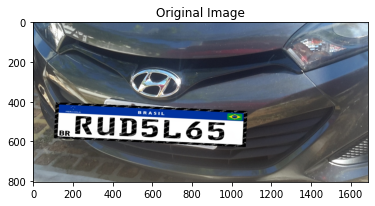

In [125]:
#read the uploaded the image
image = cv2.imread('car4.JPG')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

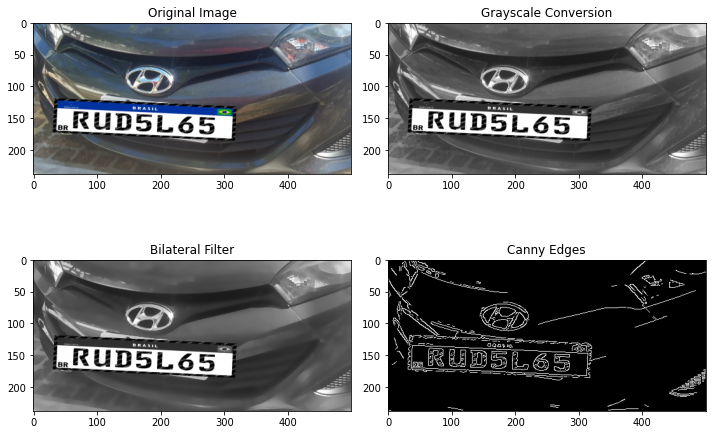

In [126]:
image = imutils.resize(image, width=500)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# Convert RGB to Gray scale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal using iterative bilateral filter
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
NumberPlateCnt = None 

# loop over our contours to find the license plate
#count = 0
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        NumberPlateCnt = approx 
        x,y,w,h = cv2.boundingRect(c)
        ROI = img[y:y+h, x:x+w]
        break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

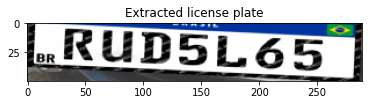

In [127]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

In [130]:
def rotate():
    coordinates = {}
    #add the y-coordinate of our licence plate contour to the dictionary
    for i, x in enumerate(NumberPlateCnt):
        coordinates[i] = x[0][1]

    # Find the index of the most bottom and second most bottom coordinate of the contour
    sorted_coord = sorted(coordinates.items(), key=lambda x:x[1], reverse=True)
    sorted_coord = dict(sorted_coord)
    sorted_coord_index = [key for key in sorted_coord]
    b1_index = sorted_coord_index[0]
    b2_index = sorted_coord_index[1]

    #Check wheich id the left coordnate and which is the right coordinate
    if NumberPlateCnt[b1_index][0][0] < NumberPlateCnt[b2_index][0][0]:
        left_x = NumberPlateCnt[b1_index][0][0]
        left_y = NumberPlateCnt[b1_index][0][1]
        right_x = NumberPlateCnt[b2_index][0][0]
        right_y = NumberPlateCnt[b2_index][0][1]
    else:
        left_x = NumberPlateCnt[b2_index][0][0]
        left_y = NumberPlateCnt[b2_index][0][1]
        right_x = NumberPlateCnt[b1_index][0][0]
        right_y = NumberPlateCnt[b1_index][0][1]

    #Calculate the angle of rotation
    p = right_y - left_y    
    b = right_x - left_x
    h = (p**2+b**2)**0.5
    theta = math.asin(p/h) * (180/3.14)

    #Rotate the image by the angle of rotation(theta)
    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if p>0:
        hyp=result.shape[0]-p//2
    else:
        hyp=result.shape[0]+p//2

    result=result[0:hyp, :]
    return result



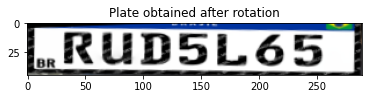

In [131]:
result = rotate()
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()


In [132]:
#Find the contours of the characters in licence plate
def find_contours(dimensions, img) :

    #Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            char = cv2.subtract(255, char)

            #Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [133]:
#Find characters in the resulting images
def segment_characters(image) :

    #Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    #Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    #Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    #Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

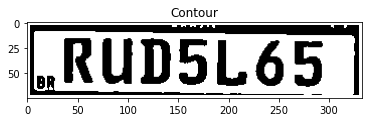

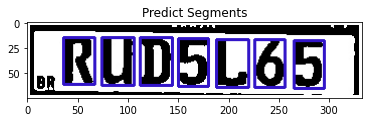

In [134]:
char=segment_characters(result)

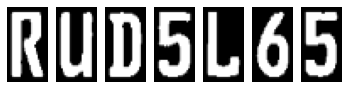

In [135]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [56]:
#mount the drive containng the dataset in zip file
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
#unzip the data file
!unzip gdrive/MyDrive/data.zip

Archive:  gdrive/MyDrive/data.zip
   creating: data/train/
   creating: data/train/class_0/
  inflating: data/train/class_0/class_0_10.jpg  
  inflating: data/train/class_0/class_0_11.jpg  
  inflating: data/train/class_0/class_0_13.jpg  
  inflating: data/train/class_0/class_0_14.jpg  
  inflating: data/train/class_0/class_0_15.jpg  
  inflating: data/train/class_0/class_0_18.jpg  
  inflating: data/train/class_0/class_0_19.jpg  
  inflating: data/train/class_0/class_0_2.jpg  
  inflating: data/train/class_0/class_0_20.jpg  
  inflating: data/train/class_0/class_0_21.jpg  
  inflating: data/train/class_0/class_0_22.jpg  
  inflating: data/train/class_0/class_0_23.jpg  
  inflating: data/train/class_0/class_0_24.jpg  
  inflating: data/train/class_0/class_0_25.jpg  
  inflating: data/train/class_0/class_0_26.jpg  
  inflating: data/train/class_0/class_0_27.jpg  
  inflating: data/train/class_0/class_0_29.jpg  
  inflating: data/train/class_0/class_0_3.jpg  
  inflating: data/train/clas

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
#training data for our model
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28),  
        batch_size=1,
        class_mode='sparse')

#validation data for our model
validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28),  
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [18]:
#Simple Convolutional Neural network
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [31]:
batch_size = 1
#fit the model
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0688 - accuracy: 0.9780 - val_loss: 0.0669 - val_accuracy: 0.9722
Epoch 2/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0443 - accuracy: 0.9838 - val_loss: 0.0713 - val_accuracy: 0.9769
Epoch 3/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0949 - accuracy: 0.9676 - val_loss: 0.0398 - val_accuracy: 0.9815
Epoch 4/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0435 - accuracy: 0.9803 - val_loss: 0.0437 - val_accuracy: 0.9769
Epoch 5/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0337 - accuracy: 0.9884 - val_loss: 0.0603 - val_accuracy: 0.9769
Epoch 6/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0999 - accuracy: 0.9745 - val_loss: 0.0391 - val_accuracy: 0.9815
Epoch 7/25
864/864 [==============================] - 8s 9ms/step - loss: 0.0690 - accuracy: 0.9722 - val_loss: 0.3010 - val_accuracy: 0.9676
Epoch 

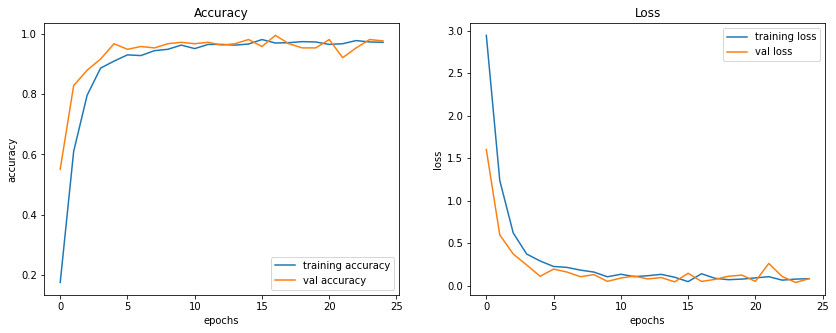

In [23]:
#Plot accuracy and loss graph
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [32]:
# Save the weights
model.save_weights('./weights')

In [33]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('./weights')

In [54]:
#Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
#Returns the characters in string format 
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict(img)[0] #predicting the class
        classes_x=np.argmax(y_)
        character = dic[classes_x]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

RUD5L65


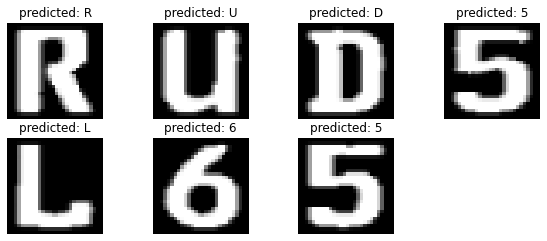

In [55]:
#Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()